In [1]:
import pandas as pd
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom
import os

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

In [2]:
INPUT_PATH = "F:/rsna-intracranial-hemorrhage-detection/"

In [3]:
submission = pd.read_csv(INPUT_PATH + "stage_2_sample_submission.csv")
submission.head(10)

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5
7,ID_d62ec3412_intraparenchymal,0.5
8,ID_d62ec3412_intraventricular,0.5
9,ID_d62ec3412_subarachnoid,0.5


In [4]:
train = pd.read_csv(INPUT_PATH + "stage_2_train.csv")
train.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [5]:
label = train.Label.values
train.Label.isnull().sum() #nenhuma label nula

0

In [6]:
#Organizando as colunas: colocando o tipo de cada hemorragia em uma coluna
train = train.ID.str.rsplit("_", n=1, expand=True)
train.loc[:, "label"] = label
train.head()

,0,1,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [7]:
#Renomeando
train = train.rename({0: "id", 1: "subtype"}, axis=1)

subtype_counts = train.groupby("subtype").label.value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1] / train.groupby("subtype").size() * 100
train.head()

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [8]:
#Lendo os ids das submissoes e organizando as colunas
test = submission.ID.str.rsplit("_", n=1, expand=True)
test = test.rename({0: "id", 1: "subtype"}, axis=1)
test.loc[:, "label"] = 0
test.head()

,id,subtype,label
0,ID_0fbf6a978,epidural,0
1,ID_0fbf6a978,intraparenchymal,0
2,ID_0fbf6a978,intraventricular,0
3,ID_0fbf6a978,subarachnoid,0
4,ID_0fbf6a978,subdural,0


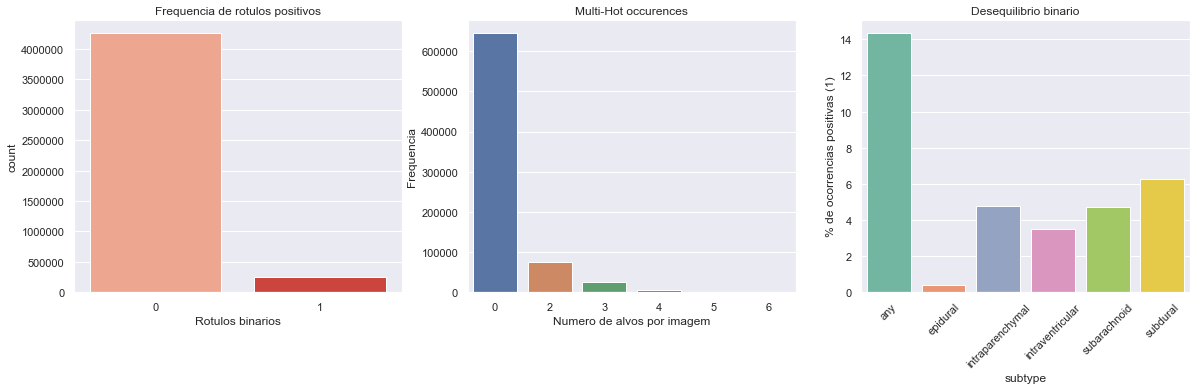

In [9]:
multi_target_count = train.groupby("id").label.sum()

fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.countplot(train.label, ax=ax[0], palette="Reds")
ax[0].set_xlabel("Rotulos binarios")
ax[0].set_title("Frequencia de rotulos positivos");

sns.countplot(multi_target_count, ax=ax[1])
ax[1].set_xlabel("Numero de alvos por imagem")
ax[1].set_ylabel("Frequencia")
ax[1].set_title("Multi-Hot occurences")

sns.barplot(x=subtype_counts.index, y=subtype_counts.values, ax=ax[2], palette="Set2")
plt.xticks(rotation=45); 
ax[2].set_title("Desequilibrio binario")
ax[2].set_ylabel("% de ocorrencias positivas (1)");

In [10]:
train.head()

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [11]:
train.id.nunique()

752803

In [12]:
train_images_dir = INPUT_PATH + "stage_2_train/"
train_images = listdir(train_images_dir)

In [13]:
print('5 Training images', train_images[:5])

5 Training images ['ID_000012eaf.dcm', 'ID_000039fa0.dcm', 'ID_00005679d.dcm', 'ID_00008ce3c.dcm', 'ID_0000950d7.dcm']


In [14]:
test_images_dir = INPUT_PATH + "stage_2_test/" 
test_images = listdir(test_images_dir)

In [15]:
print('5 Test images', test_images[:5])

5 Test images ['ID_000009146.dcm', 'ID_00007b8cb.dcm', 'ID_000134952.dcm', 'ID_000176f2a.dcm', 'ID_0001af484.dcm']


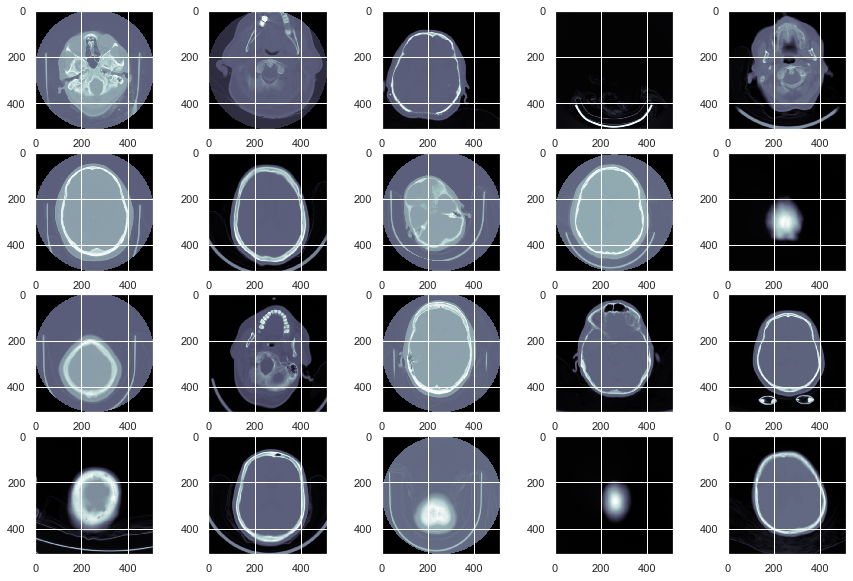

In [16]:
#Plotando imagens com pydicom (imagens dcm)
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 4
for i in range(1, columns*rows +1):
    ds = pydicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    fig.add_subplot

In [17]:
print(ds) #printa o tipo da imagem

(0008, 0018) SOP Instance UID                    UI: ID_000270f8b
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_4942f4e0'
(0020, 000d) Study Instance UID                  UI: ID_7b6962cbb9
(0020, 000e) Series Instance UID                 UI: ID_597a2eb6cf
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125', '-88', '292.300049']
(0020, 0037) Image Orientation (Patient)         DS: ['1', '0', '0', '0', '1', '0']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.48828125', '0.48828125']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 12
(0028, 0102) High Bit 

In [18]:
#Atributos e resoluções da imagem
im = ds.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint16
(512, 512)


(-0.5, 511.5, 511.5, -0.5)

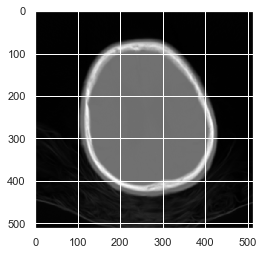

In [19]:
#plot de uma imagem unica
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('on')

In [20]:
train.head()

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [21]:
#Soma de todos os subtipos de hemorragia
gbSub = train.groupby('subtype').sum()
gbSub

,label
subtype,
any,107933
epidural,3145
intraparenchymal,36118
intraventricular,26205
subarachnoid,35675
subdural,47166


Text(0.5, 1.0, 'Total Images by Subtype')

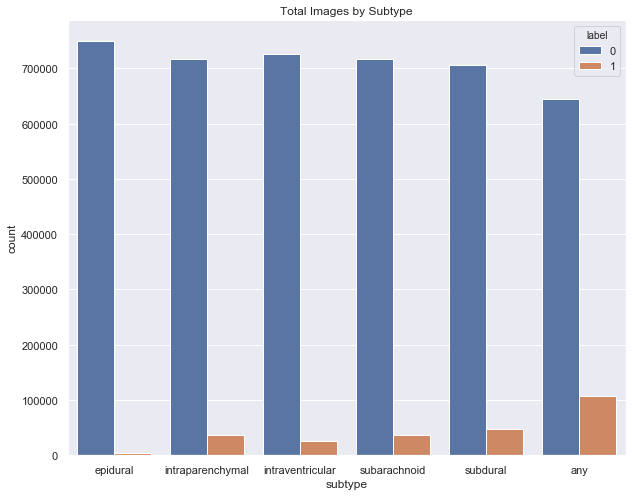

In [22]:
fig=plt.figure(figsize=(10, 8))

sns.countplot(x="subtype", hue="label", data=train)

plt.title("Total Images by Subtype")

In [23]:
#VIZUALIZAÇÃO DE CADA HEMORRAGIA

def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 


In [24]:
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    #obtem os campos das imagens DICOM
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data): #obtendo as resoluções
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [27]:
train_images_dir

def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        ''''
        image = pydicom.read_file(os.path.join(train_images_dir,'ID_'+images[im]+ '.dcm')).pixel_array
        i = im // width
        j = im % width
        axs[i,j].imshow(image, cmap=plt.cm.bone) 
        axs[i,j].axis('off')'''''
        
        data = pydicom.read_file(os.path.join(train_images_dir,images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
        
    plt.suptitle(title)
    plt.show()

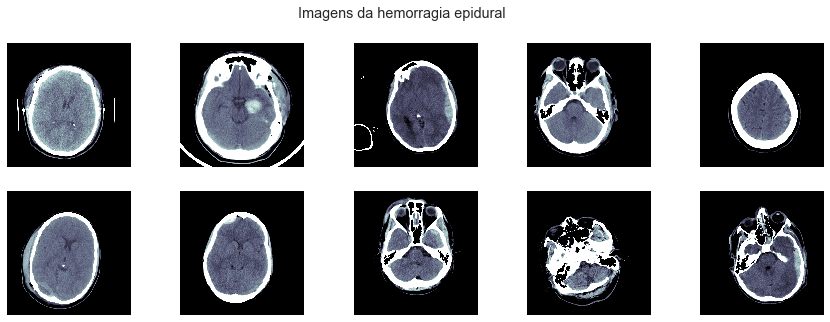

In [28]:
view_images(train[(train['subtype'] == 'epidural') & (train['label'] == 1)][:10].id.values, title = 'Imagens da hemorragia epidural')

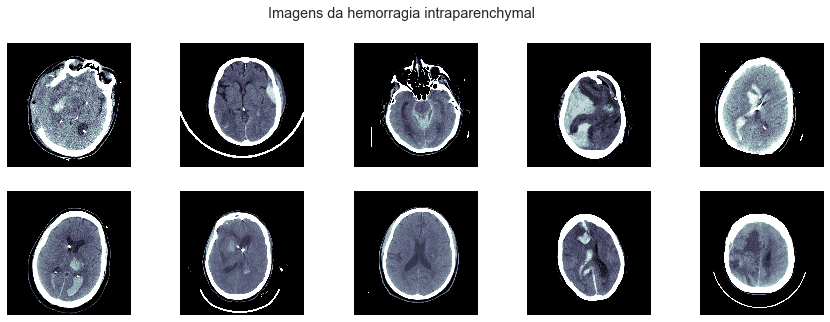

In [29]:
view_images(train[(train['subtype'] == 'intraparenchymal') & (train['label'] == 1)][:10].id.values, title = 'Imagens da hemorragia intraparenchymal')

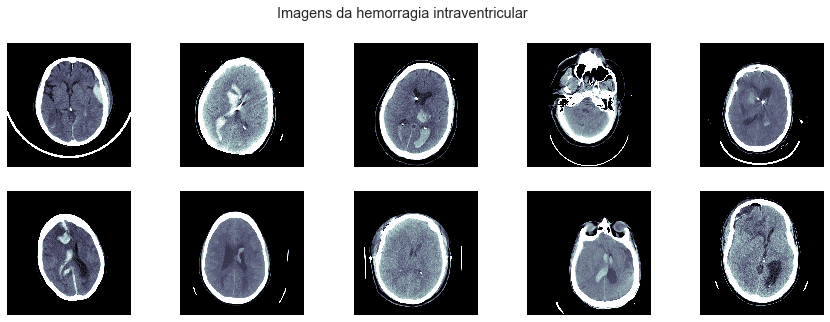

In [30]:
view_images(train[(train['subtype'] == 'intraventricular') & (train['label'] == 1)][:10].id.values, title = 'Imagens da hemorragia intraventricular')

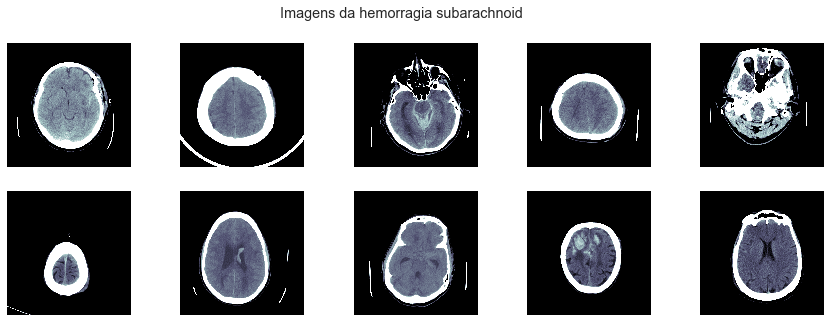

In [31]:
view_images(train[(train['subtype'] == 'subarachnoid') & (train['label'] == 1)][:10].id.values, title = 'Imagens da hemorragia subarachnoid')

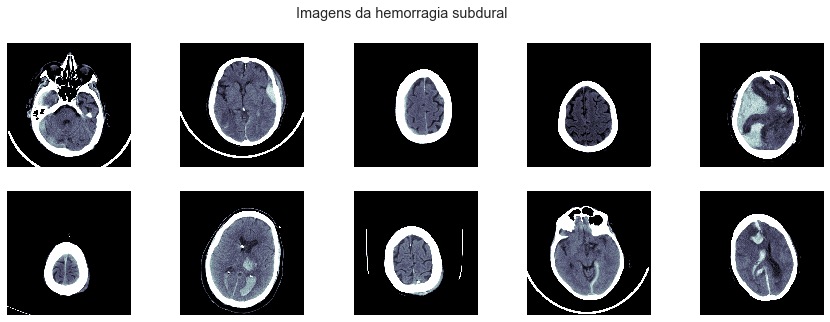

In [32]:
view_images(train[(train['subtype'] == 'subdural') & (train['label'] == 1)][:10].id.values, title = 'Imagens da hemorragia subdural')